In [4]:
pip install opencv-python-headless numpy torch torchvision scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [5]:
import os

# Replace with your actual path
data_path = '/content/drive/MyDrive/Project5_Ag_Crop and weed detection/agri_data'
images_dir = os.path.join(data_path, 'images')
labels_dir = os.path.join(data_path, 'labels')

# List files to check paths
print("Images:", os.listdir(images_dir)[:5])  # Print first 5 image files
print("Labels:", os.listdir(labels_dir)[:5])  # Print first 5 label files


Images: ['agri_0_2906.jpeg', 'agri_0_3213.jpeg', 'agri_0_2320.jpeg', 'agri_0_3075.jpeg', 'agri_0_3008.jpeg']
Labels: ['agri_0_2158.txt', 'agri_0_3647.txt', 'agri_0_3682.txt', 'agri_0_2714.txt', 'agri_0_4214.txt']


In [6]:
# Create dataset.py
dataset_code = """
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class AgriDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_name = os.path.join(self.labels_dir, self.image_files[idx].replace('.jpeg', '.txt'))
        if not os.path.exists(label_name):
            raise FileNotFoundError(f"Label file {label_name} not found.")

        with open(label_name, 'r') as file:
            label = int(file.readline().strip().split()[0])

        if self.transform:
            image = self.transform(image)

        return image, label
"""
with open('dataset.py', 'w') as f:
    f.write(dataset_code)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

def train_val_split(dataset, val_percent=0.2):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(indices, test_size=val_percent, random_state=42)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split(dataset)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


NameError: name 'dataset' is not defined

In [7]:
# Create model.py
model_code = """
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32*30*30, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32*30*30)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
"""
with open('model.py', 'w') as f:
    f.write(model_code)


In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from model import SimpleCNN
from dataset import AgriDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Function to split dataset into training and validation sets
def train_val_split(dataset, val_percent=0.2):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(indices, test_size=val_percent, random_state=42)

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    return train_dataset, val_dataset

# Hyperparameters
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define dataset and dataloaders
images_dir = '/content/drive/MyDrive/Project5_Ag_Crop and weed detection/agri_data/images'
labels_dir = '/content/drive/MyDrive/Project5_Ag_Crop and weed detection/agri_data/labels'
dataset = AgriDataset(images_dir=images_dir, labels_dir=labels_dir, transform=transform)
train_dataset, val_dataset = train_val_split(dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = SimpleCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'model.pth')


Epoch 1/10, Loss: 0.5006
Validation Loss: 0.2333, Accuracy: 0.9269
Epoch 2/10, Loss: 0.2451
Validation Loss: 0.1916, Accuracy: 0.9269
Epoch 3/10, Loss: 0.1663
Validation Loss: 0.1302, Accuracy: 0.9462
Epoch 4/10, Loss: 0.1177
Validation Loss: 0.1589, Accuracy: 0.9500
Epoch 5/10, Loss: 0.0726
Validation Loss: 0.2253, Accuracy: 0.9462
Epoch 6/10, Loss: 0.0795
Validation Loss: 0.1926, Accuracy: 0.9462
Epoch 7/10, Loss: 0.0583
Validation Loss: 0.2448, Accuracy: 0.9269
Epoch 8/10, Loss: 0.0542
Validation Loss: 0.1952, Accuracy: 0.9346
Epoch 9/10, Loss: 0.0415
Validation Loss: 0.2041, Accuracy: 0.9385
Epoch 10/10, Loss: 0.0248
Validation Loss: 0.2768, Accuracy: 0.9192


In [9]:
# Imports
import torch
import cv2
from torchvision import transforms
from model import SimpleCNN

# Load model function
def load_model(model_path='model.pth'):
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set model to evaluation mode
    return model

# Preprocess image function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Predict function
def predict(image_path, model):
    image = preprocess_image(image_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return 'crop' if preds.item() == 0 else 'weed'

# Load the model
model = load_model('model.pth')

# Predict on a sample image
image_path = '/content/drive/MyDrive/Project5_Ag_Crop and weed detection/agri_data/images/agri_0_6.jpeg'  # Replace with your image path
prediction = predict(image_path, model)
print(f'The predicted class for the image is: {prediction}')


The predicted class for the image is: weed


The predicted class for the image is: weed


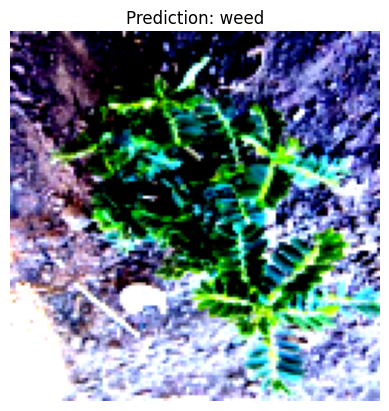

In [14]:
# Imports
import torch
import cv2
from torchvision import transforms
from model import SimpleCNN
import matplotlib.pyplot as plt

# Load model function
def load_model(model_path='model.pth'):
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set model to evaluation mode
    return model

# Preprocess image function
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} not found.")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image {image_path}. The image file might be corrupted or empty.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Predict function
def predict(image_path, model):
    image = preprocess_image(image_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return 'crop' if preds.item() == 0 else 'weed', image.cpu().squeeze().permute(1, 2, 0)

# Load the model
model = load_model('model.pth')

# Predict on a sample image
image_path = '/content/weed_1.jpeg'  # Replace with your image path
try:
    prediction, image = predict(image_path, model)
    print(f'The predicted class for the image is: {prediction}')

    # Display the image
    plt.imshow(image)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')  # Hide the axis
    plt.show()
except Exception as e:
    print(e)


The predicted class for the image is: crop


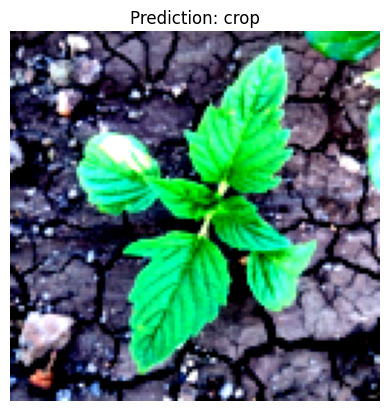

In [13]:
# Imports
import torch
import cv2
from torchvision import transforms
from model import SimpleCNN
import matplotlib.pyplot as plt

# Load model function
def load_model(model_path='model.pth'):
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set model to evaluation mode
    return model

# Preprocess image function
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} not found.")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image {image_path}. The image file might be corrupted or empty.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Predict function
def predict(image_path, model):
    image = preprocess_image(image_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return 'crop' if preds.item() == 0 else 'weed', image.cpu().squeeze().permute(1, 2, 0)

# Load the model
model = load_model('model.pth')

# Predict on a sample image
image_path = '/content/crop_1.jpeg'  # Replace with your image path
try:
    prediction, image = predict(image_path, model)
    print(f'The predicted class for the image is: {prediction}')

    # Display the image
    plt.imshow(image)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')  # Hide the axis
    plt.show()
except Exception as e:
    print(e)
